<a href="https://colab.research.google.com/github/kiranraou/Python-Projects/blob/main/IBM_stock_price_prediction_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Sequence Learning** -Assignment 2

**IBM Stock Prediction using a multi-layer RNN/GRU model.** 

Problem Statement 1

**Dataset Description**

**Dataset: IBM_2006-01-01_to_2018-01-01.csv**

IBM_2006-01-01_to_2018-01-01.csv contains files of IBM stocks, labeled by their 
stock ticker name. 

Files have the following columns: 

Date - in format: yy-mm-dd 

Open - price of the stock at market open (this is NYSE data so all in USD)

High - Highest price reached in the day 

Low Close - Lowest price reached in the day 

Volume - Number of shares traded 

Name - the stock's ticker name

**Mounting Google Drive.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing the libraries.**

In [18]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [19]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

**Reading Datasets.**

In [20]:
# First, we get the data
dataset = pd.read_csv('/content/drive/MyDrive/NIT Warangal _Industry Project/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [21]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

**Visualizing**

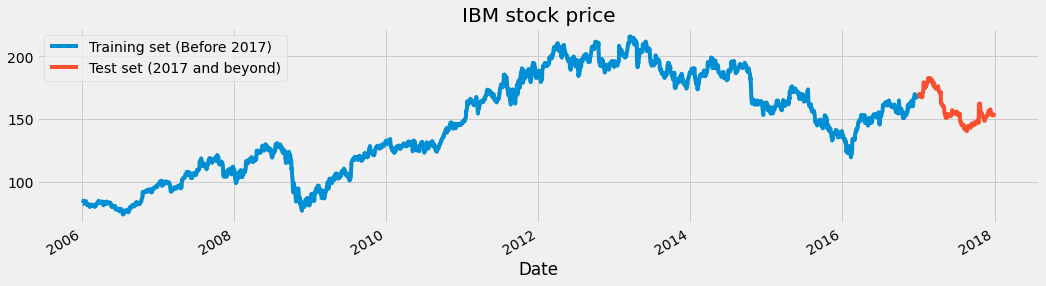

In [22]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [23]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [24]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [25]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## **LSTM Architecture.**

**RNN with Units: 50.**

In [26]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 32s 62ms/step - loss: 0.0494
Epoch 2/50
85/85 [==============================] - 5s 63ms/step - loss: 0.0114
Epoch 3/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0085
Epoch 4/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0071
Epoch 5/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0065
Epoch 6/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0054
Epoch 7/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0060
Epoch 8/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0051
Epoch 9/50
85/85 [==============================] - 5s 63ms/step - loss: 0.0040
Epoch 10/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0038
Epoch 11/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0038
Epoch 12/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0039
Epoch 13/50
85/85 [=================

In [27]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [28]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

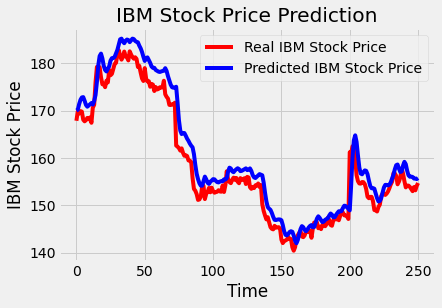

In [29]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)


In [30]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 3.2656994287788756.


## **GRU Architecture.**

**GRU with Units: 50.**

In [31]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
19/19 [==============================] - 9s 61ms/step - loss: 0.1561
Epoch 2/50
19/19 [==============================] - 1s 61ms/step - loss: 0.0386
Epoch 3/50
19/19 [==============================] - 1s 61ms/step - loss: 0.0077
Epoch 4/50
19/19 [==============================] - 1s 61ms/step - loss: 0.0050
Epoch 5/50
19/19 [==============================] - 1s 62ms/step - loss: 0.0043
Epoch 6/50
19/19 [==============================] - 1s 61ms/step - loss: 0.0038
Epoch 7/50
19/19 [==============================] - 1s 61ms/step - loss: 0.0035
Epoch 8/50
19/19 [==============================] - 1s 60ms/step - loss: 0.0037
Epoch 9/50
19/19 [==============================] - 1s 63ms/step - loss: 0.0034
Epoch 10/50
19/19 [==============================] - 1s 62ms/step - loss: 0.0032
Epoch 11/50
19/19 [==============================] - 1s 62ms/step - loss: 0.0031
Epoch 12/50
19/19 [==============================] - 1s 62ms/step - loss: 0.0032
Epoch 13/50
19/19 [==================

In [32]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

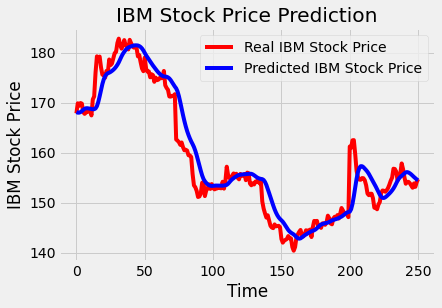

In [33]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [34]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.375972791530975.


In [35]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

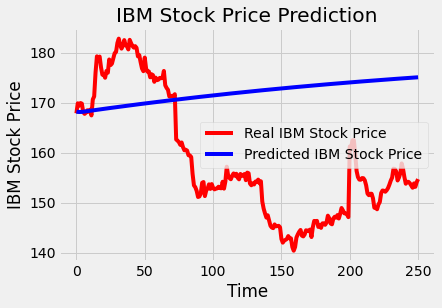

In [36]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [37]:
# Evaluating the sequence
return_rmse(test_set,sequence)

The root mean squared error is 19.274136523327066.
